<a href="https://colab.research.google.com/github/Jonatala/Adventureworks2017/blob/main/New_Hybrid_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 7.9 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630156 sha256=f6be6cf5372e06cbd465ed8da75b0772ebb707167d91606b7e15bb7480880ca3
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [42]:
import os
import sys
import numpy as np
import pandas as pd
import surprise as sp
import seaborn as sns
import scipy

from math import sqrt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.decomposition import TruncatedSVD
from surprise import KNNBasic,accuracy
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

In [3]:
!unzip /content/drive/MyDrive/goodbooks-10k.zip #&& rm *.zip

Archive:  /content/drive/MyDrive/goodbooks-10k.zip
  inflating: book_tags.csv           
  inflating: books.csv               
  inflating: ratings.csv             
  inflating: sample_book.xml         
  inflating: tags.csv                
  inflating: to_read.csv             


In [38]:
books = pd.read_csv('books.csv')

book_tags = pd.read_csv('tags.csv')

ratings_data = pd.read_csv('ratings.csv')

tags_data = pd.read_csv('book_tags.csv')

In [39]:
ratings_data.drop_duplicates(subset =["user_id","book_id"], keep = False, inplace = True) 

In [ ]:
books = books.dropna()
books.drop_duplicates(subset='original_title',keep=False,inplace=True)

In [43]:
top_rated = books.sort_values('average_rating', ascending=False)
tf_top_rated = top_rated[:20]
fig = px.bar(tf_top_rated, x="average_rating", y="original_title", title='Top Rated Books and Their Ratings',
             orientation='h', color='original_title', width=1300, height=600)
fig.show()

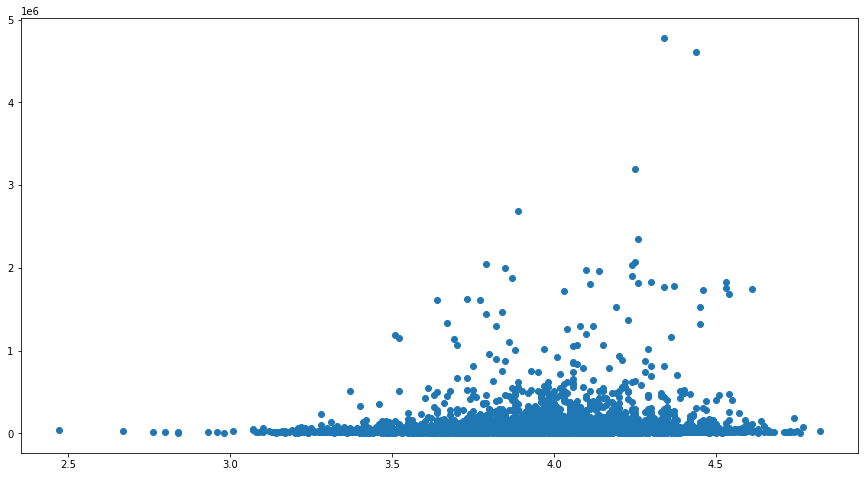

In [44]:
plt.figure(figsize=(15,8))
plt.scatter(x=books['average_rating'], y=books['ratings_count'])

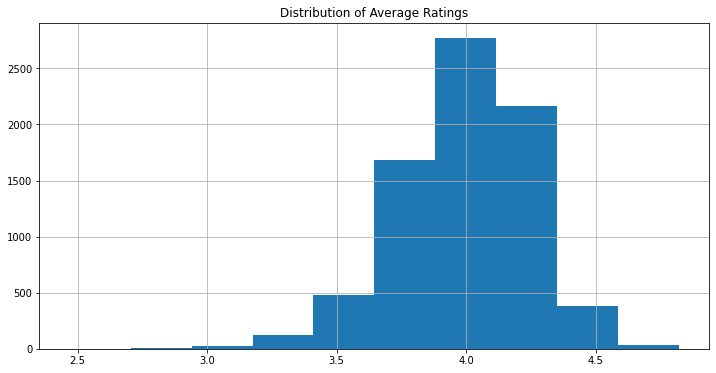

In [45]:
#distribution of average ratings of all the 10000 books
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.title("Distribution of Average Ratings")
books["average_rating"].hist()
display()

In [46]:
fig = px.treemap(tf_top_rated, path=['original_title'], values='average_rating',title='Top Rated Books', width=900, height=600)
fig.show()

In [47]:
forty_top_authors = top_rated[:40]
fig = px.treemap(forty_top_authors, path=['authors'], values='average_rating',title='Popular Authors', width=900, height=600)
fig.show()

In [4]:
books_df = pd.read_csv('books.csv')
ratings_df = pd.read_csv('ratings.csv')
books_df.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [5]:
book_tags = pd.read_csv('book_tags.csv', encoding = "ISO-8859-1")
book_tags.head()
tags = pd.read_csv('tags.csv')
tags.tail()
tags_join_DF = pd.merge(book_tags, tags, left_on='tag_id', right_on='tag_id', how='inner')
tags_join_DF.head()
books_with_tags = pd.merge(books_df, tags_join_DF, left_on='book_id', right_on='goodreads_book_id', how='inner')

In [7]:
books_with_tags.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,goodreads_book_id,tag_id,count,tag_name
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,2767052,30574,11314,to-read
1,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,2767052,11305,10836,fantasy
2,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,2767052,11557,50755,favorites
3,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,2767052,8717,35418,currently-reading
4,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,2767052,33114,25968,young-adult


In [8]:
# removing all columns that we will not use

ignore_columns = ['books_count', 'isbn', 'best_book_id',  'work_id', 'isbn13', 'language_code', 'work_ratings_count', 'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'image_url', 'small_image_url'] #'goodreads_book_id'
books_df = books_df.drop(ignore_columns, axis = 1)
books_df.head()

,id,book_id,authors,original_publication_year,original_title,title,average_rating,ratings_count
0,1,2767052,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",4.34,4780653
1,2,3,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,4.44,4602479
2,3,41865,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",3.57,3866839
3,4,2657,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,4.25,3198671
4,5,4671,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,3.89,2683664


In [9]:
# removing books that have less than 50 ratings, also removing books that have 0 ratings

popularity_threshold = 50
books_df = books_df.query('ratings_count >= @popularity_threshold')
rating_threshold = 1.0
books_df = books_df.query('average_rating >= @rating_threshold')
ignore_columns = ['average_rating']
books_df = books_df.drop(ignore_columns, axis = 1)

In [10]:
combine_rating_df = pd.merge(ratings_df, books_df, on='book_id')
ignore_columns = ['authors', 'original_publication_year', 'original_title', 'title']
combine_rating_df = combine_rating_df.drop(ignore_columns, axis=1)
combine_rating_df.head()

,book_id,user_id,rating,id,ratings_count
0,1,314,5,27,1678823
1,1,439,3,27,1678823
2,1,588,5,27,1678823
3,1,1169,4,27,1678823
4,1,1185,4,27,1678823


In [11]:
# For Content-Based Filtering

temp_df = books_with_tags.groupby('book_id')['tag_name'].apply(' '.join).reset_index()
temp_df.head()
tag_books_df = pd.merge(books_df, temp_df, left_on='book_id', right_on='book_id', how='inner')
tag_books_df['corpus'] = (pd.Series(tag_books_df[['authors', 'tag_name']]
                .fillna('')
                .values.tolist()
                ).str.join(' '))

In [12]:
# For Content-Based Filtering

def find_recommendation(book_title):
  tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
  tfidf_matrix = tf.fit_transform(books_df['authors'])
  cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
  indices = pd.Series(books_df.index, index=books_df['title'])
  
  tf_corpus = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
  tfidf_matrix_corpus = tf_corpus.fit_transform(tag_books_df['corpus'])
  cosine_sim_corpus = linear_kernel(tfidf_matrix_corpus, tfidf_matrix_corpus)

  # Build a 1-dimensional array with book titles
  titles = tag_books_df['title']
  indices = pd.Series(tag_books_df.index, index=tag_books_df['title'])
  titles1 = books_df['title']
  indices1 = pd.Series(books_df.index, index=books_df['title'])

  # Function that get book recommendations based on the cosine similarity score of books tags
  def corpus_recommendations(title):
      idx = indices1[title]
      sim_scores = list(enumerate(cosine_sim_corpus[idx]))
      sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
      sim_scores = sim_scores[1:21]
      book_indices = [i[0] for i in sim_scores]
      return titles.iloc[book_indices]

  ret = corpus_recommendations(book_title)
  return ret

In [13]:
def collaborative_filtering(books_input, subsetGroup):
  pearsonCorrelationDict = {}
  subsetGroup = subsetGroup[0: 1000]

  #For every user group in our subset
  for name, group in subsetGroup:
    #Let's start by sorting the input and current user group so the values aren't mixed up later on
    group = group.sort_values(by='book_id')
    books_input = books_input.sort_values(by='book_id')
    #Get the N for the formula
    nRatings = len(group)
    #Get the review scores for the movies that they both have in common
    temp_df = books_input[books_input['book_id'].isin(group['book_id'].tolist())]
    #And then store them in a temporary buffer variable in a list format to facilitate future calculations
    tempRatingList = temp_df['rating'].tolist()
    #Let's also put the current user group reviews in a list format
    tempGroupList = group['rating'].tolist()
    #Now let's calculate the pearson correlation between two users, so called, x and y
    Sxx = sum([i**2 for i in tempRatingList]) - pow(sum(tempRatingList),2)/float(nRatings)
    Syy = sum([i**2 for i in tempGroupList]) - pow(sum(tempGroupList),2)/float(nRatings)
    Sxy = sum( i*j for i, j in zip(tempRatingList, tempGroupList)) - sum(tempRatingList)*sum(tempGroupList)/float(nRatings)
    
    #If the denominator is different than zero, then divide, else, 0 correlation.
    if Sxx != 0 and Syy != 0:
      pearsonCorrelationDict[name] = Sxy/sqrt(Sxx*Syy)
    else:
      pearsonCorrelationDict[name] = 0

    pearsonDF = pd.DataFrame.from_dict(pearsonCorrelationDict, orient='index')
    pearsonDF.columns = ['similarityIndex']
    pearsonDF['user_id'] = pearsonDF.index
    pearsonDF.index = range(len(pearsonDF))
    topUsers=pearsonDF.sort_values(by='similarityIndex', ascending=False)[0:50]
    topUsersRating=topUsers.merge(ratings_df, left_on='user_id', right_on='user_id', how='inner')
    topUsersRating['weightedRating'] = topUsersRating['similarityIndex']*topUsersRating['rating']
    tempTopUsersRating = topUsersRating.groupby('book_id').sum()[['similarityIndex','weightedRating']]
    tempTopUsersRating.columns = ['sum_similarityIndex','sum_weightedRating']
    #Creates an empty dataframe
    recommendation_df = pd.DataFrame()
    #Now we take the weighted average
    recommendation_df['weighted average recommendation score'] = tempTopUsersRating['sum_weightedRating']/tempTopUsersRating['sum_similarityIndex']
    recommendation_df['book_id'] = tempTopUsersRating.index
    recommendation_df = recommendation_df.sort_values(by='weighted average recommendation score', ascending=False)
    return recommendation_df

In [14]:
def do_collaborative_filtering(books_input, subsetGroup):
  recommendation_df = collaborative_filtering(books_input, subsetGroup)
  temp_df = books_df.loc[books_df['book_id'].isin(recommendation_df.head(15)['book_id'].tolist())]
  temp_df[["title", "authors", "original_publication_year"]].rename(columns={'title': 'Title', 'authors': 'Authors','original_publication_year': "Publication"})
  
  return temp_df.head(15)

In [15]:
def do_content_based_filtering(books_input, userInput):
  for i in range(0, len(userInput)):
    title = inputBooks2['original_title'][i]
    recommendation_df = pd.DataFrame()
    recommendation_df = find_recommendation(title)
    recommendation_df.columns = ['book_id', 'title']
    print("Book Recommendations for '{}': \n".format(title))
    print(recommendation_df.head(5))

In [16]:
def hybrid_recommendation_system(book_input, userInput, userSub, userSubGroup):
  similar_users = len(userSub)
  if similar_users > 4000:
    recommendation_df = do_collaborative_filtering(book_input, userSubsetGroup)
    return recommendation_df[["title", "authors", "original_publication_year"]].rename(columns={'title': 'Title', 'authors': 'Authors','original_publication_year': "Publication"})
  else:
    do_content_based_filtering(book_input, userInput)

In [29]:
userInput1 = [
            {'original_title':'The Hound of the Baskervilles', 'rating': 5},
            {'original_title': 'A Study in Scarlet', 'rating': 4},
            {'original_title':'The Da Vinci Code', 'rating': 4},
            {'original_title':'The Murder of Roger Ackroyd', 'rating': 5},
            {'original_title':"The Day of the Jackal", 'rating': 4},
            {'original_title':'Hell House', 'rating': 3}
         ] 
inputBooks1 = pd.DataFrame(userInput1)
inputBooks1

,original_title,rating
0,The Hound of the Baskervilles,5
1,A Study in Scarlet,4
2,The Da Vinci Code,4
3,The Murder of Roger Ackroyd,5
4,The Day of the Jackal,4
5,Hell House,3


In [30]:
inputId1 = books_df[books_df['original_title'].isin(inputBooks1['original_title'].tolist())]
inputBooks1 = pd.merge(inputId1, inputBooks1)
ignore_columns = ['authors', 'original_publication_year', 'original_title', 'title']
inputBooks1 = inputBooks1.drop(ignore_columns, axis = 1)
inputBooks1

,id,book_id,ratings_count,rating
0,26,968,1447148,4
1,446,102868,201499,4
2,618,8921,154517,5
3,989,540020,85883,4
4,1410,16328,71354,5
5,4613,33547,22644,3


In [20]:
userSubset = ratings_df[ratings_df['book_id'].isin(inputBooks1['book_id'].tolist())]
rating_threshold = 1.0
userSubset = userSubset.query('rating >= @rating_threshold')
userSubset.head()

,book_id,user_id,rating
96697,968,75,3
96698,968,173,2
96699,968,883,5
96700,968,931,4
96701,968,1407,4


In [21]:
userSubsetGroup = userSubset.groupby(['user_id'])
userSubsetGroup = sorted(userSubsetGroup,  key=lambda x: len(x[1]), reverse=True)
userSubsetGroup[0:3]

[(42163,         book_id  user_id  rating
  881396     8921    42163       3
  881397     8921    42163       4), (75,        book_id  user_id  rating
  96697      968       75       3), (173,        book_id  user_id  rating
  96698      968      173       2)]

In [22]:
len(userSubset)

198

In [ ]:
hybrid_recommendation_system(inputBooks1, userInput1, userSubset, userSubsetGroup)

In [24]:
userInput2 = [
            {'original_title': 'The Graveyard Book', 'rating': 5}, 
         ] 
inputBooks2 = pd.DataFrame(userInput2)
inputBooks2

,original_title,rating
0,The Graveyard Book,5


In [32]:
inputId2 = books_df[books_df['original_title'].isin(inputBooks2['original_title'].tolist())]
inputBooks2 = pd.merge(inputId2, inputBooks2)
ignore_columns = ['authors', 'original_publication_year', 'original_title', 'title']
inputBooks2_tmp = inputBooks2.drop(ignore_columns, axis = 1)
inputBooks2_tmp

,id,book_id,ratings_count,rating
0,312,2213661,302303,5


In [33]:
userSubset2 = ratings_df[ratings_df['book_id'].isin(inputBooks2_tmp['book_id'].tolist())]
rating_threshold = 1.0
userSubset2 = userSubset2.query('rating >= @rating_threshold')
userSubset2.head()

,book_id,user_id,rating


In [34]:
userSubsetGroup2 = userSubset2.groupby(['user_id'])
userSubsetGroup2 = sorted(userSubsetGroup2,  key=lambda x: len(x[1]), reverse=True)
userSubsetGroup2[0:3]

[]

In [35]:
len(userSubset2)

0

In [36]:
hybrid_recommendation_system(inputBooks2, userInput2, userSubset2, userSubsetGroup2)

Book Recommendations for 'The Graveyard Book': 

281                                              Coraline
116     A Wrinkle in Time (A Wrinkle in Time Quintet, #1)
1737                                    When You Reach Me
4649               The Grey King (The Dark Is Rising, #4)
737     Mrs. Frisby and the Rats of NIMH (Rats of NIMH...
Name: title, dtype: object
